<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
scipy 1.2.1
pandas 0.24.2
matplotlib 3.1.0
statsmodels 0.9.0
sklearn 0.22.2.post1

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data1'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [6]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [7]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [9]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [95]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)

In [13]:
train_score_mean = cross_val_score(knn,X_train, y_train,cv=skf).mean()
train_score_mean

0.5594389847433981

In [14]:
valid_score_mean = knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
acc_valid = accuracy_score(y_valid,y_pred)
acc_valid

0.584024650391088

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
''' ВАШ КОД ЗДЕСЬ '''
print(f'{round(train_score_mean,3)} {round(acc_valid,3)}')

0.559 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=17,oob_score=True)
forest.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=17, verbose=0,
                       warm_start=False)

In [28]:
forest.oob_score_

0.7172322698638488

In [18]:
y_pred2 = forest.predict(X_valid)
acc_valid2 = accuracy_score(y_valid,y_pred2)
acc_valid2

0.7312159279450107

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [19]:
print(f'{round(forest.oob_score_,3)} {round(acc_valid2,3)}')

0.717 0.731


In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

In [31]:
!cat answer4_2.txt

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [20]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [21]:
logit = LogisticRegression(random_state=17,n_jobs=-1)

In [22]:
logr_cv_mean = cross_val_score(logit,X_train,y_train,cv=skf,n_jobs=-1).mean()
logr_cv_mean

0.7606189739891912

In [23]:
logit.fit(X_train,y_train,)
y_pred3 = logit.predict(X_valid)
acc_valid3 = accuracy_score(y_valid,y_pred3)
acc_valid3

0.7767243422611994

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [24]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,cv=skf,random_state = 17,\
                                            n_jobs=-1,multi_class = 'multinomial')#, max_iter=1000)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 25.5 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [29]:
logit_grid_searcher1.scores_[31][:,0]

array([0.31819567, 0.31331911, 0.32713415])

In [30]:
logit_mean_cv_scores1 = [logit_grid_searcher1.scores_[31][:,i].mean() for i in range(10)]
logit_mean_cv_scores1

[0.31954964280669934,
 0.4730739686244774,
 0.552022360820987,
 0.6487503500073099,
 0.7143884597943816,
 0.751779616813236,
 0.7608222260217117,
 0.7581806929773047,
 0.7502551646211373,
 0.7386726793586131]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
matrix = logit_grid_searcher1.scores_[31]
matrix

array([[0.31819567, 0.47637915, 0.55105151, 0.65437367, 0.71258763,
        0.75038098, 0.76196282, 0.75647668, 0.75068577, 0.73879915],
       [0.31331911, 0.47576958, 0.54891801, 0.64218226, 0.704968  ,
        0.73818958, 0.74733313, 0.74550442, 0.73849436, 0.72203596],
       [0.32713415, 0.46707317, 0.55609756, 0.64969512, 0.72560976,
        0.76676829, 0.77317073, 0.77256098, 0.76158537, 0.75518293]])

In [50]:
(np.argmax(matrix)//10,np.argmax(matrix)%10)

(2, 6)

In [57]:
matrix.max(),logit_grid_searcher1.Cs[6]

(0.7731707317073171, 1.0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

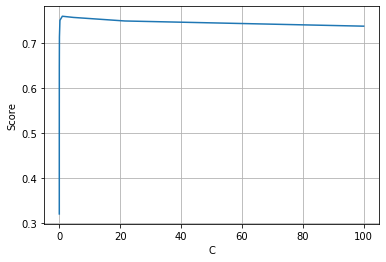

In [62]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()
plt.show()


**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [63]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,cv=skf,random_state = 17,\
                                            n_jobs=-1,multi_class = 'multinomial')
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 30s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [64]:
logit_grid_searcher2.scores_

{31: array([[0.73483694, 0.75952454, 0.76165803, 0.76135325, 0.76043889,
         0.76074368, 0.75921975, 0.75891496, 0.75861018, 0.75891496,
         0.75830539, 0.75739104, 0.75708625, 0.75525754, 0.75586711,
         0.75586711, 0.7540384 , 0.7540384 , 0.75342883, 0.75281926],
        [0.72325511, 0.74672356, 0.74824749, 0.74885706, 0.74977141,
         0.74916184, 0.74855227, 0.7479427 , 0.74824749, 0.74641877,
         0.74702835, 0.74672356, 0.74459006, 0.74459006, 0.74398049,
         0.74276135, 0.74154221, 0.74062786, 0.73910393, 0.73879915],
        [0.74634146, 0.77164634, 0.77408537, 0.77256098, 0.77286585,
         0.77408537, 0.7722561 , 0.77134146, 0.77195122, 0.77195122,
         0.7722561 , 0.77164634, 0.77164634, 0.77164634, 0.77134146,
         0.77042683, 0.77073171, 0.77012195, 0.7695122 , 0.76890244]]),
 33: array([[0.73483694, 0.75952454, 0.76165803, 0.76135325, 0.76043889,
         0.76074368, 0.75921975, 0.75891496, 0.75861018, 0.75891496,
         0.75830539, 

In [209]:
logit_grid_searcher2.scores_[50][2,2]==logit_grid_searcher2.scores_[50][2,5]

True

In [68]:
logit_mean_cv_scores2 = [logit_grid_searcher2.scores_[50][:,i].mean() for i in range(len(logit_c_values2))]
logit_mean_cv_scores2

[0.7348111695076108,
 0.7592981455187914,
 0.761330294154816,
 0.7609237591156771,
 0.7610253851319372,
 0.761330294154816,
 0.7600093727621214,
 0.7593997095868551,
 0.7596029616193753,
 0.7590949864085657,
 0.7591966124248257,
 0.7585869802236577,
 0.7577742198863623,
 0.7571646496333906,
 0.7570630236171304,
 0.7563517653997022,
 0.755437440994343,
 0.7549294038353368,
 0.7540149865076828,
 0.7535069493486767]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [200]:
matrix2 = logit_grid_searcher2.scores_[50]
(np.argmax(matrix2)//len(logit_c_values2),np.argmax(matrix2)%len(logit_c_values2))

(2, 2)

In [204]:
logit_grid_searcher2.Cs

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

In [210]:
logit_grid_searcher2.Cs[2],logit_grid_searcher2.Cs[5]

(0.8263157894736842, 1.9157894736842107)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

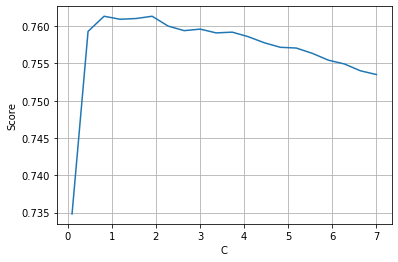

In [75]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()
plt.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [81]:
y_pred3 = logit_grid_searcher2.predict(X_valid)

In [82]:
logit_cv_acc = accuracy_score(y_valid,y_pred3)
logit_cv_acc

0.7755392273050485

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [222]:
logit_grid_searcher2.C_


array([0.82631579, 0.82631579, 0.82631579, 0.82631579, 0.82631579,
       0.82631579, 0.82631579, 0.82631579, 0.82631579, 0.82631579])

In [83]:
scores4_mean = cross_val_score(logit_grid_searcher2,X_train, y_train,cv=skf).mean()
scores4_mean 

0.7616350483072036

0.7616350483072036 0.7755392273050485

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [84]:
from sklearn.svm import LinearSVC

In [86]:
svm = LinearSVC(C=1,random_state=17)
scores_mean6=cross_val_score(svm,X_train,y_train,cv=skf).mean()
svm.fit(X_train,y_train)
cvm_score6 = accuracy_score(y_valid,svm.predict(X_valid))
print(scores_mean6,cvm_score6 )

0.7507639141844025 0.7769613652524295


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [96]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm,svm_params1,cv=skf,n_jobs=-1,return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 2s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [97]:
svm_grid_searcher1.best_score_,svm_grid_searcher1.best_params_

(0.6939663385890184, {'C': 7777.777800000001})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [98]:
svm_grid_searcher1.cv_results_

{'mean_fit_time': array([0.25515167, 7.78118555, 7.7382706 , 7.87894694, 8.59982872,
        8.6113739 , 8.75904934, 7.93893035, 7.57114061, 6.21981295]),
 'std_fit_time': array([0.00736379, 0.35006709, 0.2821231 , 0.62079393, 0.31458765,
        0.5064584 , 0.27020609, 0.21635681, 0.18585645, 0.13438235]),
 'mean_score_time': array([0.        , 0.002328  , 0.00066543, 0.00520722, 0.        ,
        0.00266099, 0.00099611, 0.        , 0.01041428, 0.        ]),
 'std_score_time': array([0.        , 0.00047064, 0.00094105, 0.00736412, 0.        ,
        0.00047154, 0.00140872, 0.        , 0.00736401, 0.        ]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

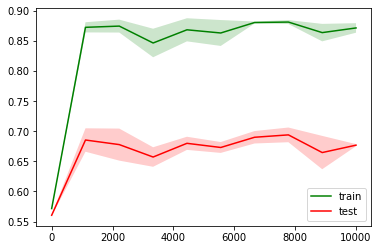

In [99]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [100]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm,svm_params2,cv=skf,n_jobs=-1,return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=Non

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [101]:
svm_grid_searcher2.best_score_,svm_grid_searcher2.best_params_

(0.7670206386611259, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

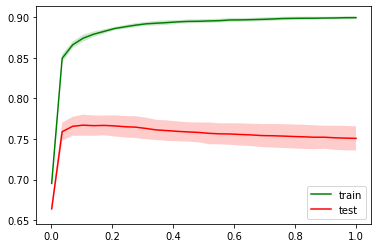

In [102]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [103]:
clf = LinearSVC(C=svm_grid_searcher2.best_params_['C'],random_state=17)
clf.fit(X_train,y_train)
svm_cv_acc = accuracy_score(y_valid, clf.predict(X_valid))
svm_cv_acc

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [106]:
mean_scores_svm2 = cross_val_score(svm_grid_searcher2.best_estimator_,X_train,y_train,cv=skf,n_jobs=-1).mean()
y_pred_svm2 = svm_grid_searcher2.best_estimator_.predict(X_valid)
mean_scores_svm2,accuracy_score(y_valid,y_pred_svm2)

(0.7670206386611259, 0.7807537331121118)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [109]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    #Загрузка
    with open(path_to_X_pickle,'rb') as X_pickle:
        X_sparse = pickle.load(X_pickle)
    
    with open(path_to_y_pickle,'rb') as y_pickle:
        y = pickle.load(y_pickle)
    
    #Разбиение на обучающую и валидационную выборки    
    X_train,X_valid,y_train,y_valid = train_test_split(X_sparse,y,\
                                                       random_state=random_state,test_size=test_size,stratify=y)
    
    #Средняя точность на кроссвалидации для обучающей выборки    
    mean_cv_accuracy = cross_val_score(estimator,X_train,y_train, cv=cv).mean()
    
    #Точность для валидационной выборки
    estimator.fit(X_train,y_train)
    val_accuracy = accuracy_score(y_valid,estimator.predict(X_valid))
    
    return mean_cv_accuracy,val_accuracy
    
    
    
    
    

**Убедитесь, что функция работает.**

In [110]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [111]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [112]:
PATH_TO_DATA2 = 'data2'

In [125]:
import time
time.time()

1585135639.5973463

In [128]:
%%time
estimator = svm_grid_searcher2.best_estimator_
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    t_start = time.time()
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA2,f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA2,f'y_10users_s{session_length}_w{window_size}.pkl')
        ac_cv, v_ac = model_assessment(svm_grid_searcher2.best_estimator_,path_to_X_pkl,path_to_y_pkl,\
                                      skf, random_state=17, test_size=0.3)
        duration = time.time() - t_start
        print(f'session lenght {session_length}, window size {window_size}: mean CV accuracy: {ac_cv}, validation accuracy: {v_ac}, duration of iteration: {duration} s')           

session lenght 15, window size 10: mean CV accuracy: 0.8243252292702751, validation accuracy: 0.8404835269021095, duration of iteration: 8.740145206451416 s
session lenght 10, window size 10: mean CV accuracy: 0.7670206386611259, validation accuracy: 0.7807537331121118, duration of iteration: 4.815398216247559 s
session lenght 15, window size 7: mean CV accuracy: 0.8495024256089474, validation accuracy: 0.8543222166915547, duration of iteration: 12.47264051437378 s
session lenght 10, window size 7: mean CV accuracy: 0.7983645917156946, validation accuracy: 0.8073668491786958, duration of iteration: 7.281831741333008 s
session lenght 7, window size 7: mean CV accuracy: 0.754765400423003, validation accuracy: 0.7617388418782147, duration of iteration: 4.2636377811431885 s
session lenght 15, window size 5: mean CV accuracy: 0.8670355547005402, validation accuracy: 0.8752963489805595, duration of iteration: 18.856114864349365 s
session lenght 10, window size 5: mean CV accuracy: 0.81775202

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

mean CV accuracy: 0.8670355547005402, validation accuracy: 0.8752963489805595

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

При увеличении длины сессии и уменьшении ширины окна качество возрастает

In [130]:
%%time
estimator = svm_grid_searcher2.best_estimator_ 

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    t_start = time.time()
    path_to_X_pkl = os.path.join(PATH_TO_DATA2,f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA2,f'y_150users_s{session_length}_w{window_size}.pkl')
    ac_cv, v_ac = model_assessment(estimator,path_to_X_pkl,path_to_y_pkl,\
                                      skf, random_state=17, test_size=0.3)
    duration = time.time() - t_start
    print(f'session lenght {session_length}, window size {window_size}: mean CV accuracy: {ac_cv}, validation accuracy: {v_ac}, duration of iteration: {duration} s')

session lenght 5, window size 5: mean CV accuracy: 0.4083611011164474, validation accuracy: 0.42171606560568453, duration of iteration: 838.0018553733826 s
session lenght 7, window size 7: mean CV accuracy: 0.4366487102001489, validation accuracy: 0.45295840855673264, duration of iteration: 814.1012179851532 s
session lenght 10, window size 10: mean CV accuracy: 0.46307591254574465, validation accuracy: 0.4836276942538802, duration of iteration: 788.0590643882751 s
Wall time: 40min 40s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

session lenght 10, window size 10: mean CV accuracy: 0.46307591254574465, validation accuracy: 0.4836276942538802, duration of iteration: 788.0590643882751 s

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [132]:
with open(os.path.join(PATH_TO_DATA2, 'X_sparse_150users_s10_w10.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA2, 'y_150users_s10_w10.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [133]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [223]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs = [logit_grid_searcher2.Cs[5]],\
                                         random_state=17,n_jobs=-1,multi_class='ovr',cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 12min 45s


LogisticRegressionCV(Cs=[1.9157894736842107], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [224]:
logit_cv_150users.scores_


{6: array([[0.99596509],
        [0.99646555],
        [0.9958087 ]]), 13: array([[0.99627788],
        [0.99637171],
        [0.99627788]]), 15: array([[0.99521441],
        [0.99518313],
        [0.9953708 ]]), 16: array([[0.99199274],
        [0.99199274],
        [0.99155485]]), 28: array([[0.99042883],
        [0.99027243],
        [0.99036627]]), 31: array([[0.99433862],
        [0.99440118],
        [0.99446373]]), 33: array([[0.99368177],
        [0.99396328],
        [0.9936505 ]]), 39: array([[0.9859873 ],
        [0.9867067 ],
        [0.98501767]]), 46: array([[0.99802946],
        [0.99824841],
        [0.99784179]]), 49: array([[0.99521441],
        [0.99524569],
        [0.99512058]]), 50: array([[0.99440118],
        [0.99433862],
        [0.99424478]]), 53: array([[0.99361922],
        [0.99377561],
        [0.99374433]]), 65: array([[0.99684089],
        [0.996966  ],
        [0.99702856]]), 66: array([[0.99474524],
        [0.99477652],
        [0.99490163]]), 82: ar

In [225]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
       
    print('User {}, CV score: {}'.format(user_id,logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9960797806345333
User 13, CV score: 0.9963091551718745
User 15, CV score: 0.995256117523172
User 16, CV score: 0.9918467778090561
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9944011760658097
User 33, CV score: 0.9937651830304547
User 39, CV score: 0.9859038920688542
User 46, CV score: 0.9980398903172666
User 49, CV score: 0.9951935608311699
User 50, CV score: 0.9943281932584739
User 53, CV score: 0.9937130524537862
User 65, CV score: 0.9969451482072295
User 66, CV score: 0.9948077945638234
User 82, CV score: 0.9963717118638766
User 85, CV score: 0.9963717118638766
User 89, CV score: 0.9908771490830232
User 92, CV score: 0.994422028296477
User 100, CV score: 0.9944950111038128
User 102, CV score: 0.9911586541970326
User 103, CV score: 0.9805448687873385
User 105, CV score: 0.9969034437458948
User 106, CV score: 0.9948494990251583
User 118, CV score: 0.9909292796596917
User 119, CV score: 0.9965906602858841
User 120, CV score: 0.994286488797139
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [189]:
class_distr = np.bincount(y_train_150.astype('int'))
print(class_distr)
y_train_150.shape

[  0   0   0 ...   0   0 475]


(95913,)

In [190]:
class_distr[int(user_id)] - class_distr[user_id]

0

In [230]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] =logit_cv_150users.scores_[user_id].mean()\
                            - (y_train_150.shape[0] - class_distr[user_id])/y_train_150.shape[0]
    

In [227]:
acc_diff_vs_constant

{6: 0.011677249173730253,
 13: 0.000604714689353858,
 15: 0.0008549414573623126,
 16: 0.007131462888242401,
 28: 0.0024084326420819036,
 31: -5.2130576668418804e-05,
 33: 0.0012198554940414663,
 39: 0.001991388028734553,
 46: 0.0009174981493643708,
 49: 0.0013658211087130834,
 50: 0.00017724396067275716,
 53: 0.0016681784533899569,
 65: 2.0852230667389726e-05,
 66: -5.213057666852983e-05,
 82: 2.0852230667389726e-05,
 85: 0.00017724396067264614,
 89: 0.0008028108806940049,
 92: 0.0002710789986758444,
 100: -0.0002502267680085657,
 102: 0.0007194019580243349,
 103: 0.003544879213453811,
 105: 0.0008862198033635638,
 106: 0.007631916424259533,
 118: 0.0009279242646983432,
 119: 0.0006464191506886374,
 120: 0.0006255669200211367,
 126: 0.001011333187367791,
 127: 0.00409746332613925,
 128: 0.005098370398173291,
 138: -5.2130576668418804e-05,
 158: 0.00028150511400959477,
 160: 0.00028150511400959477,
 165: 0.00028150511400959477,
 172: 0.00022937453734106494,
 177: 0.0002710789986759554,


In [235]:
num_better_than_default=122

In [236]:
#num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default/np.unique(y_train_150).shape[0]

0.8133333333333334

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**


0.8133333333333334

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [238]:
sum(y_150users == 128)

2796

In [239]:
len(y_150users)

137019

In [245]:
sum(y_binary_128)

2796

In [253]:

(137019-2796)/137019

0.9795940708952773

In [246]:
y_binary_128 = [int(i) for i in y_150users == 128] 

In [247]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [283]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator,X_sparse_150users,y_binary_128,train_sizes=train_sizes,\
                                             random_state=17,cv=5)

Wall time: 1min 52s


In [271]:
n_train[np.argmax(np.array([val_test[i].mean() for i in range(val_test.shape[0])]))]

80528

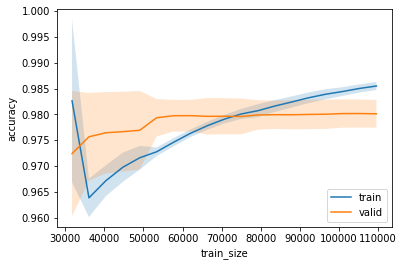

In [284]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

 Кривая точности на тесте вышла на планку, новые данные не помогут.

In [396]:
from scipy.sparse import csr_matrix
from tqdm import tqdm_notebook
import re
from glob import glob

def prepare_sparse_train_set_time(path_to_csv_files, 
                                    session_time=5):
    ''' ВАШ КОД ЗДЕСЬ'''
    
    #Загрузка файлов пользователей
    files_paths = list(glob(os.path.join(path_to_csv_files,'user*.csv')))
    files = []
    user_IDs = []
    for path in tqdm_notebook(files_paths):
        f_name = os.path.split(path)[1]
        ID = int(re.findall("[0-9]+",f_name)[0])
        user_IDs.append(ID)
        files.append(pd.read_csv(path))
    user_IDs = np.array(user_IDs)
            
    #Получение словаря сайтов с ID и частотами
   
    sites_dictionary = {}
    
    for user in tqdm_notebook(files):
        for site in user.site.values:
            if site in sites_dictionary:
               
                sites_dictionary[site] += 1                
                
            else:
                sites_dictionary[site] = 1
              
    d =  sorted(sites_dictionary.items(), key=lambda item: item[1],reverse = True)    
    sites_dict_sorted = {}
    
    for ii,pair in enumerate(d):
        
        sites_dict_sorted[pair[0]] = [ii+1,pair[1]]  #заполнение словаря ID и частотами из отсортированного d
    
    
    
            
    # Заполнение таблицы пользовательских сессий ID просмотренных пользователем сайтов при заданной длительности сессии
    Session_list = [] 
    for ind,user in enumerate(tqdm_notebook(files)):
        session = []#инициализация сессии
        session.append(user_IDs[ind])#нулевой столбец для ID пользователей
        
        sites = user.site.values#стоблец сайтов пользователя
        
        
        
        user.timestamps = pd.to_datetime(user.timestamp)#Столбец даты и времени начала просмотра сайта
        
        seconds = user.timestamps.apply(lambda x:x.timestamp()).values
        
        
       
        ufile_length = sites.shape[0] #длина файла пользователя
        site_position = 0 #позиция в сессии
        pos_in_ufile = 0 #позиция в файле
        
        duration_time_session = 0
        duration_site_on_last_session = 0
        while pos_in_ufile < ufile_length:
            if pos_in_ufile > 0:
                #Время на сайте в текущей сессии
                duration_time_site =(seconds[pos_in_ufile] - seconds[pos_in_ufile-1])/60. - duration_site_on_last_session 
                duration_site_on_last_session  = 0 #новая сессии, величина пока не нужна
                
                duration_time_session += duration_time_site #увеличиваем время сессии
                
                #print(f'{sites[pos_in_ufile-1]} ID {sites_dict_sorted[sites[pos_in_ufile-1]][0]}')
                #print(f'site: {duration_time_site} session: {duration_time_session}')
            
            if duration_time_session  > session_time:  #время сессии превышено            
                Session_list.append(session) #Сессия закончена и помещена в список
                #print('new')
                session = [] #инициализация новой сессии
                session.append(user_IDs[ind]) #нулевой столбец для ID пользователей
                site_to_start = sites[pos_in_ufile-1]#последний сайт прошлой переходит на новую сессию
                duration_time_site_over_edge = duration_time_session - session_time#время выхода за пределы
                duration_site_on_last_session  = (seconds[pos_in_ufile] - seconds[pos_in_ufile-1])/60.\
                                                    - duration_time_site_over_edge #время, проведенное на прошлой сессии
                
                duration_time_session = 0
                session.append(sites_dict_sorted[site_to_start][0])
                
            elif duration_time_session == session_time:
                Session_list.append(session)
                #print('new')
                session = [] #инициализация новой сессии
                session.append(user_IDs[ind]) #нулевой столбец для ID пользователей
                site_to_start = sites[pos_in_ufile]
                duration_time_session = 0
                session.append(sites_dict_sorted[site_to_start][0])
                pos_in_ufile += 1                
            else:
                site_to_add =  sites[pos_in_ufile] #сайт для добавления в сессию
                session.append(sites_dict_sorted[site_to_add][0])#добавление
                pos_in_ufile += 1 #переходим на следующую позицию и на след шаге будет проверять время на сайте
            
        if len(session) > 0: #обрабатываем последнюю сессию для данного пользователя
                                   
            #print('last site for user:')
            #print(f'{sites[pos_in_ufile-1]} ID {sites_dict_sorted[sites[pos_in_ufile-1]][0]}')            
            
                
            Session_list.append(session) #Добавляем последнюю сессию в список  
                
            
        
        
        
        
        """
        duration_time_session = 0
        for ind2,site in enumerate(sites):
            if ind2>0:
                duration_time_site =(seconds[ind2] - seconds[ind2-1])/60.
                durarion_time_session += duration_time_site
                print(f'{sites[ind2-1]} ID {sites_dict_sorted[sites[ind2-1]][0]} site: {duration_time_site} session: {durarion_time_session}')
            if durarion_time_session  >= session_time:
                print('new')
                durarion_time_session = 0
                Session_list.append(session)
                session = [] #инициализация новой сессии
                session.append(user_IDs[ind1]) #нулевой столбец для ID пользователей
            
            session.append(sites_dict_sorted[site][0])  #Добавляем сайт в сессию  
        
            if (ind2+1) == len(sites):
                duration_time_site =(seconds[ind2] - seconds[ind2-1])/60.
                durarion_time_session += duration_time_site
                print(f'{sites[ind2]} ID {sites_dict_sorted[sites[ind2]][0]} site: {duration_time_site} session: {durarion_time_session}')
                
                Session_list.append(session) #Добавляем сайт в сессию 
                
        """    
            
    
    
    
    """
    # Заполнение таблицы пользовательских сессий ID просмотренных пользователем сайтов
    Session_list = []  
        
    for ind,user in enumerate(tqdm_notebook(files)): 
        session = np.zeros(session_length+1)
        session[session_length] = user_IDs[ind] #заполнение стобца ID пользователей
        
        sites = user.site.values
        ufile_length = sites.shape[0]
        site_position = 0 #позиция в сессии
        pos_in_ufile = 0 #позиция в файле
        while pos_in_ufile < ufile_length:            
            session[site_position]=sites_dict_sorted[sites[pos_in_ufile]][0]#получение ID сайта из словаря по названию
            pos_in_ufile += 1
            site_position += 1
            
            if site_position == session_length:
                Session_list.append(session)                  
                session = np.zeros(session_length+1)
                session[session_length] = user_IDs[ind]
                site_position = 0
                pos_in_ufile -= session_length - window_size
           
            if (pos_in_ufile == ufile_length) & (site_position != 0):
                Session_list.append(session)
                if site_position > window_size:
                    session = np.zeros(session_length+1)
                    session[session_length] = user_IDs[ind]               
                    pos_in_ufile -= site_position - window_size
                    site_position = 0  
    
    """
    
    Sessions = pd.DataFrame(Session_list).fillna(0).values
    #print(Session_list)
  
    
    #Отделений ID пользователей от таблицы
    X, y = Sessions[:,1:],Sessions[:,0]
    
    #Получение разреженной матрицы частот встречаемости сайтов в каждой сессии      
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for s in tqdm_notebook(X):
        for ID in s:
            index = vocabulary.setdefault(ID, ID)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))

    X_sparse = csr_matrix((data, indices, indptr), dtype=int)[:,1:] 
    
    
    return X_sparse, y, Sessions

In [319]:
PATH_TO_DATA3 = 'capstone_user_identification'

In [397]:
X_toy_s5_w3, y_s5_w3,sessions = prepare_sparse_train_set_time(os.path.join(PATH_TO_DATA3,'3users'), session_time=15)                                                 
sessions.shape                       

(36, 9)

In [409]:
%%time
X_sparse10_time, y_10_time,sessions10_time = prepare_sparse_train_set_time(os.path.join(PATH_TO_DATA3,'10users'), session_time=10)                                                 
sessions10_time.shape 

Wall time: 7min 11s


(215867, 915)

In [410]:
X_train_t, X_valid_t, y_train_t, y_valid_t = train_test_split(X_sparse10_time, y_10_time, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10_time)

In [411]:
%%time
svm_grid_searcher2.best_estimator_.fit(X_train_t,y_train_t)
y_pred_svm2_t = svm_grid_searcher2.best_estimator_.predict(X_valid_t)
accuracy_score(y_valid_t,y_pred_svm2_t)

Wall time: 6min 1s


0.6035731381541359

In [412]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)
knn.fit(X_train_t,y_train_t)
y_pred_knn_t = knn.predict(X_valid_t)
accuracy_score(y_valid_t,y_pred_knn_t)

0.5918840042618242

Вывод: использование сессий по времени не улучшает результат

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.